# Train a model only on focal recordings

In [1]:
description = "train with focal only training set, increase absence samples"

In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

In [3]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [4]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import torch
from utils import plot_metrics_across_thresholds, show_sample_from_df
from opensoundscape.data_selection import resample


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
! which conda
!which pip
! which python

/Users/mikeg/miniforge3/condabin/conda
/Users/mikeg/miniforge3/envs/osfl2/bin/pip
/Users/mikeg/miniforge3/envs/osfl2/bin/python


# Set some hyperparameters

In [6]:
n_samples_per_class = 2000
one_output_neuron = True
random_seed = 44
learning_rate = 0.001
epochs=15

### Load the datasets
The original input csv needs processing so that the audio samples are multi - indexed by filename, start_time and end_time, and features were created indicating whether these clips contain a call of the target species. 



In [7]:
# # optionally load the multi-indexed datasets from disk
data_path = Path.cwd().parent.parent / "data"
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "verified_full_train_set.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")
verified_train_df = pd.read_pickle(data_path / "interim" / "train_set" / "verified_balanced_sample_of_train_set.pkl")
verified_train_df.head()

# Or build from an input dataframe with clip id as the index. 
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

,,,target_presence,probability,loss,confidence_cat
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL/recording-292954.mp3,21.0,24.0,1.0,0.987208,0.012792,3
../../data/raw/recordings/OSFL/recording-40344.mp3,127.5,130.5,1.0,0.069889,0.930111,6
../../data/raw/recordings/OSFL/recording-577870.flac,25.5,28.5,1.0,0.986357,0.013643,3
../../data/raw/recordings/OSFL/recording-292458.mp3,4.5,7.5,1.0,0.946441,0.053559,2
../../data/raw/recordings/OSFL/recording-291945.mp3,102.0,105.0,1.0,0.919413,0.080587,2


In [8]:
# Re-label the mis-labelled clips
verified_train_df.loc[verified_train_df['confidence_cat'] == 5, 'target_presence'] = 1.0
verified_train_df.loc[verified_train_df['confidence_cat'] == 6, 'target_presence'] = 0.0

train_df.loc[train_df["confidence_cat"] == 5, "target_presence"] = 1.0
train_df.loc[train_df["confidence_cat"] == 6, "target_presence"] = 0.0


# drop the clips with confidence 1 or 2 since these were hard to label. 
verified_train_df = verified_train_df[verified_train_df['confidence_cat'] != 1]
verified_train_df = verified_train_df[verified_train_df['confidence_cat'] != 2]

train_df = train_df[train_df['confidence_cat'] != 1]
train_df = train_df[train_df['confidence_cat'] != 2]

In [9]:
verified_train_df = verified_train_df.drop(columns=["probability", "loss", "confidence_cat"])
train_df = train_df.drop(columns=["probability", "loss", "confidence_cat"])

# Load focal recordings and split into train and valid sets
The focal recordings are predictions made by HawkEars - an existing multi species recognizer. The model was run on the audio recordings in the training and validation sets - and the top 2% of results were returned to be used as training data.

The validation detections need separating from the training detections because we want to see how well the model performs in new locations. 

In [10]:
focal_recs = pd.read_pickle(data_path / "interim" / "train_and_valid_set" /"focal_osfls_thresh_0.98_ngen_2601.pkl")

# Convert the focal df index to Path objects
new_index = focal_recs.index.set_levels(focal_recs.index.levels[0].map(Path), level=0)

# Split the focal clips into train and valid sets by filtering by the file paths at index of each dataset. 
focal_recs.index = new_index

# Find the audio recording file paths used for each dataframe
train_df_file_paths = train_df.index.get_level_values('file')
valid_df_file_paths = valid_df.index.get_level_values('file')
focal_recs_file_paths = focal_recs.index.get_level_values('file')

# Split the focal recordings into train and valid sets
train_focal_recs_idx = focal_recs_file_paths.isin(train_df_file_paths)
valid_focal_recs_idx = focal_recs_file_paths.isin(valid_df_file_paths)

train_focal = focal_recs[train_focal_recs_idx]
valid_focal = focal_recs[valid_focal_recs_idx]


When the human labelled tags are made, the listeners only tag the first vocalization of an individual within a time period. This isn't usually the most prominent vocalization of that individual. The focal recordings allow us to reach further into the recording - past the first vocalization - use take most prominent and clear calls. 

In [11]:
train_focal.head()

recording_id  \
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0             555135   
                                                   7.5        10.5            555135   
                                                   13.5       16.5            555135   
                                                   15.0       18.0            555135   
                                                   24.0       27.0            555135   

                                                                       label  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0       OSFL   
                                                   7.5        10.5      OSFL   
                                                   13.5       16.5      OSFL   
                                                   15.0       18.0      OSFL   
                                                   24.0       27.0      OSFL   

                                                                       score  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0       0.99   
                                                   7.5        10.5      0.99   
                                                   13.5       16.5      0.98   
                                                   15.0       18.0      0.99   
                                                   24.0       27.0      0.98   

                                                                       file_extension  \
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0                flac   
                                                   7.5        10.5               flac   
                                                   13.5       16.5               flac   
                                                   15.0       18.0               flac   
                                                   24.0       27.0               flac   

                                                                        duration  
file                                               start_time end_time            
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0            3.0  
                                                   7.5        10.5           3.0  
                                                   13.5       16.5           3.0  
                                                   15.0       18.0           3.0  
                                                   24.0       27.0           3.0

In [12]:
verified_train_df.value_counts(), train_df.value_counts(), len(train_focal)

(target_presence
 0.0                1092
 1.0                 569
 Name: count, dtype: int64,
 target_presence
 0.0                41840
 1.0                 2091
 Name: count, dtype: int64,
 2221)

# Available data
There are currently 1092 verified absent clips and 2221 focal present recordings. There are more unverified absent clips so we'll pick from there too, expecting a bit of noise. 


### Make a hash of the dataset. 
To compare one run with another, the datasets need to contain the same samples.  
The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [13]:
def get_hash_from_df(df):
    '''
    Convert the DataFrame to a hashable string.
    Take a hash of each row, then concatenate the hashes, and finally hash the concatenated hash.
    '''
    df_string_to_hash = ''.join(pd.util.hash_pandas_object(df, index=False).astype(str))

    # Use hashlib to create a hash of the entire DataFrame
    df_hash_value = hashlib.sha256(df_string_to_hash.encode()).hexdigest()

    print(df_hash_value)
    return df_hash_value

train_hash_value = get_hash_from_df(train_df)
valid_hash_value = get_hash_from_df(valid_df)

40b3cd4b078a3f4520aa90f55b9872f22532257e11532c95c90c15a6f11cf0ce
7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe


In [14]:
# These are just copied from the output of the above cell. If the dataset changes, an error will be raised. 
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

AssertionError: Training set has changed

In [ ]:
# upsample (repeat samples) or downsample so that both classes have equal numbers of samples

# add a colum  for absence class where presence is 0
train_df["target_absence"] = 1 - train_df["target_presence"]

balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)

# # drop the redundant absence column
balanced_train_df = balanced_train_df.drop(columns=["target_absence"])
balanced_valid_df = balanced_valid_df.drop(columns=["target_absence"])

balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 1.0    2000
 0.0    2000
 Name: count, dtype: int64,
 4000)

# Combine the absent samples from train_df with the focal samples


### Option 1 - Combine the absent samples from balanced_train_df with focal samples as present class

In [ ]:
absent = train_df.loc[train_df.target_presence == 0]
verified_absent = verified_train_df.loc[verified_train_df.target_presence == 0]
len(absent), len(verified_absent)


(41840, 1092)

In [ ]:
train_absent = pd.concat([verified_absent, absent.sample(5*n_samples_per_class - len(verified_absent), random_state=random_seed)])
train_absent.drop(columns=["target_absence"], inplace=True)

In [ ]:
# absent.drop(columns=["target_absence"], inplace=True)
train_focal["target_presence"] = 1.0
train_focal = train_focal[["target_presence"]].sample(n_samples_per_class, random_state=random_seed)
train_df = pd.concat([train_absent, train_focal]).sample(frac=1, random_state=random_seed)

In [ ]:
i=0

../../data/raw/recordings/OSFL/recording-320810.mp3 363.0 366.0


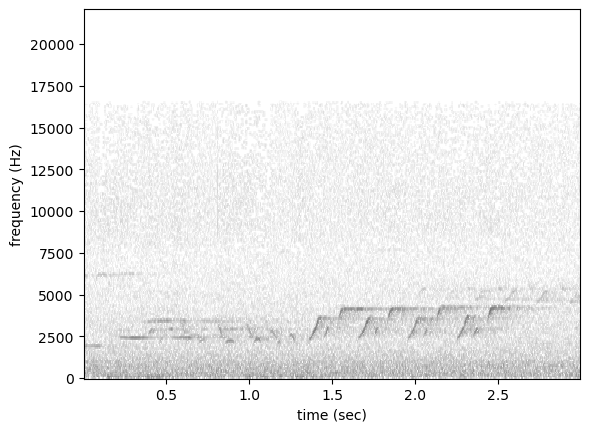

In [ ]:
show_sample_from_df(train_df, i)
i-=1

### Option 2: combine absent samples from the training set with focal samples and human labelled samples. 

### Shuffle the datasets since the resampling method sorts the data. 

In [ ]:
shuffled_balanced_valid_df = balanced_valid_df.sample(frac=1, random_state=random_seed)
shuffled_verified_train_df = verified_train_df.sample(frac=1, random_state=random_seed)

In [ ]:
shuffled_verified_train_df.columns

Index(['target_presence'], dtype='object')

# Define the model

In [ ]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = False

# Inspect the input

In [ ]:
present_t = train_df.loc[train_df.target_presence == 1]
absent_t = train_df.loc[train_df.target_presence == 0]
present_v = shuffled_balanced_valid_df.loc[shuffled_balanced_valid_df.target_presence == 1]
absent_v = shuffled_balanced_valid_df.loc[shuffled_balanced_valid_df.target_presence == 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

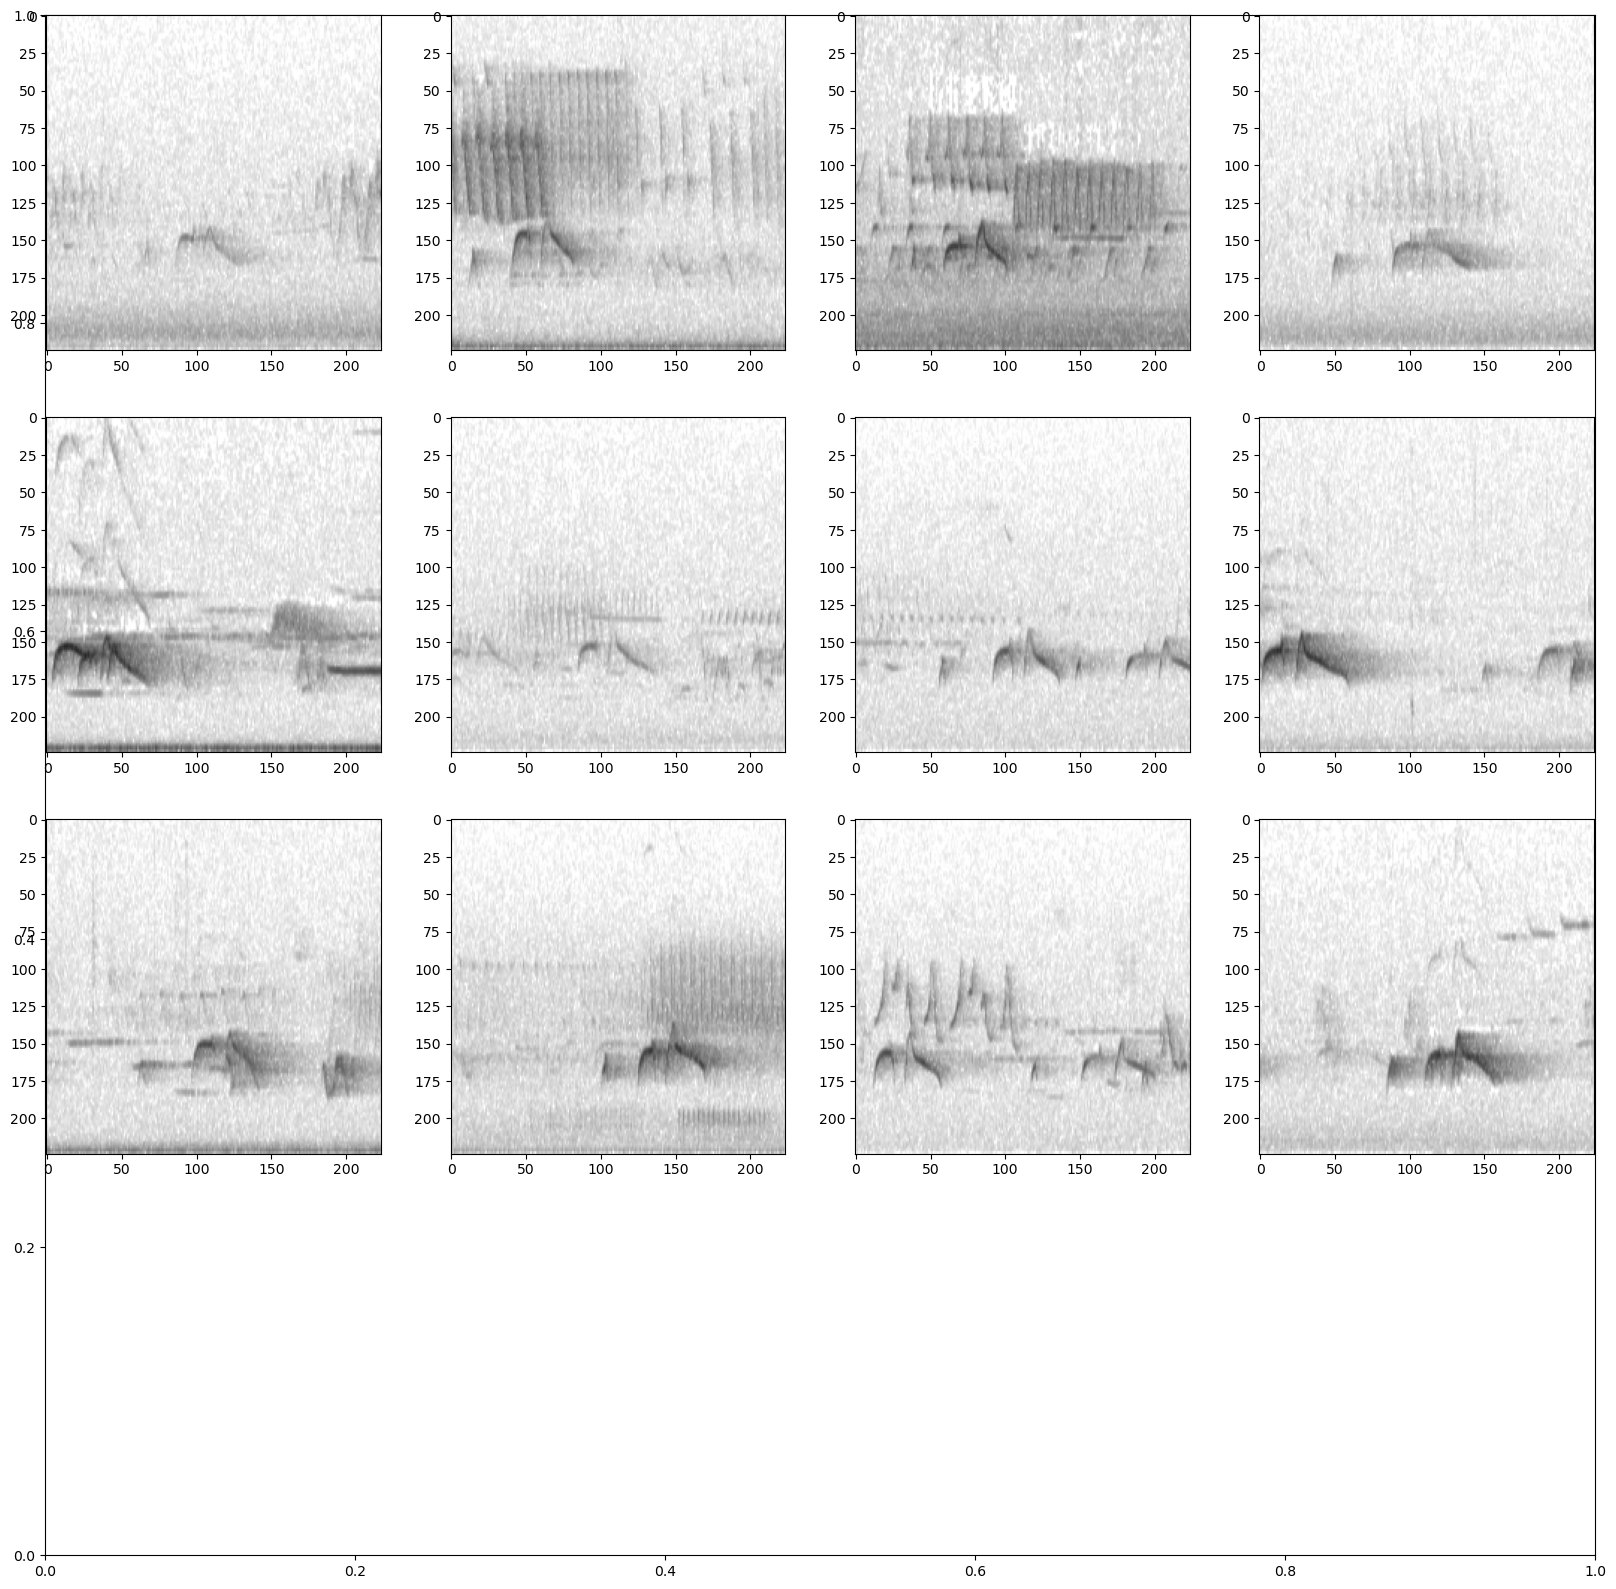

In [ ]:
#generate a dataset with the samples we wish to generate and the model's preprocessor
inspection_dataset = opso.AudioFileDataset(present_t.sample(12), model.preprocessor)
inspection_dataset.bypass_augmentations = True

samples = [sample.data for sample in inspection_dataset]
_ = show_tensor_grid(samples,4,invert=True)

In [ ]:
model.preprocessor.pipeline

load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Augmentation Action calling <function trim_aud...
trim_audio           Action calling <function trim_audio at 0x163b0...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_tensor                                                       Action
time_mask            Augmentation Action calling <function time_mas...
frequency_mask       Augmentation Action calling <function frequenc...
add_noise            Augmentation Action calling <function tensor_a...
rescale              Action calling <function scale_tensor at 0x163...
random_affine        Augmentation Action calling <function torch_ra...
dtype: object

In [ ]:
model.preprocessor.pipeline.rescale.params

input_mean    0.5
input_std     0.5
dtype: object

# Optionally load a pretrained model from disk for further training

In [ ]:
# opso.cnn.load_model(model_save_path / 'first_focal_unbalanced2024-03-12.model') 

In [ ]:
model.optimizer_params['lr'] = learning_rate
model.optimizer_params

{'lr': 1e-05, 'momentum': 0.9, 'weight_decay': 0.0005}

In [ ]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

In [ ]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


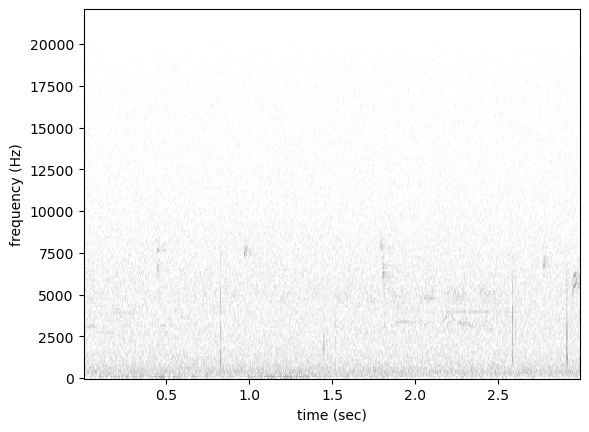

In [ ]:
show_sample_from_df(present=True, df = shuffled_verified_train_df)

In [ ]:
print(f'model.device is: {model.device}')

model.device is: mps


In [ ]:
%set_env WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"

env: WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"


# Weights and biases initialization

In [ ]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "1.15.1-mjg-osfl-revisit-opso-training-cycle".
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [ ]:
epochs

15

In [ ]:
train_df.value_counts()

target_presence
0.0                10000
1.0                 2000
Name: count, dtype: int64

In [ ]:
# Loop 1 on the first balanced training set
model.train(
    train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 2, # main /no parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 1,
    save_path=str(model_save_path),
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 0 [batch 0/188, 0.00%] 
	DistLoss: 0.718
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.997823129251701 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.995283446712018 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.995283446712018 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 0 [batch 100/188, 53.19%] 
	DistLoss: 0.617
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.9086848072562357 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.997823129251701 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.167

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Training Epoch 1


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 1 [batch 0/188, 0.00%] 
	DistLoss: 0.328
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.995283446712018 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.997823129251701 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.995283446712018 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 1 [batch 100/188, 53.19%] 
	DistLoss: 0.450
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.997823129251701 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.9086848072562357 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.169

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Training Epoch 2


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 2 [batch 0/188, 0.00%] 
	DistLoss: 0.459
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.997823129251701 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.997823129251701 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.995283446712018 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 2 [batch 100/188, 53.19%] 
	DistLoss: 0.448
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.9086848072562357 sec instead of 3.0 sec
  warnings.warn(error_msg)


KeyboardInterrupt: 

In [ ]:
# wandb.log({"class counts": shuffled_verified_train_df.value_counts()})

# Adding a second training set reduced validation score. 

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [ ]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"cleaned_1000_1000{dt}")

# Show metrics

In [ ]:
model.train_metrics

{0: {'target_presence': {'au_roc': 0.46723249999999994,
   'avg_precision': 0.4808667006739298,
   'precision': 0.49949238578680205,
   'recall': 0.984,
   'f1': 0.6626262626262626,
   'support': 1000},
  'precision': 0.48307952622673433,
  'recall': 0.499,
  'f1': 0.34490536432284,
  'jaccard': 0.2546239027523372,
  'hamming_loss': 0.501,
  'map': 0.4808667006739298,
  'au_roc': 0.46723249999999994},
 1: {'target_presence': {'au_roc': 0.508168,
   'avg_precision': 0.5098155242779471,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.6666666666666666,
   'support': 1000},
  'precision': 0.25,
  'recall': 0.5,
  'f1': 0.3333333333333333,
  'jaccard': 0.25,
  'hamming_loss': 0.5,
  'map': 0.5098155242779471,
  'au_roc': 0.508168},
 2: {'target_presence': {'au_roc': 0.49672800000000006,
   'avg_precision': 0.4913705907633911,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.6666666666666666,
   'support': 1000},
  'precision': 0.25,
  'recall': 0.5,
  'f1': 0.3333333333333333,
  'jaccard

In [ ]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.5,
   'avg_precision': 0.5,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.6666666666666666,
   'support': 500},
  'precision': 0.25,
  'recall': 0.5,
  'f1': 0.3333333333333333,
  'jaccard': 0.25,
  'hamming_loss': 0.5,
  'map': 0.5,
  'au_roc': 0.5},
 1: {'target_presence': {'au_roc': 0.5,
   'avg_precision': 0.5,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.6666666666666666,
   'support': 500},
  'precision': 0.25,
  'recall': 0.5,
  'f1': 0.3333333333333333,
  'jaccard': 0.25,
  'hamming_loss': 0.5,
  'map': 0.5,
  'au_roc': 0.5},
 2: {'target_presence': {'au_roc': 0.5,
   'avg_precision': 0.5,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.6666666666666666,
   'support': 500},
  'precision': 0.25,
  'recall': 0.5,
  'f1': 0.3333333333333333,
  'jaccard': 0.25,
  'hamming_loss': 0.5,
  'map': 0.5,
  'au_roc': 0.5},
 3: {'target_presence': {'au_roc': 0.5,
   'avg_precision': 0.5,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.666666

# Confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

  0%|          | 0/1000 [00:00<?, ?it/s]

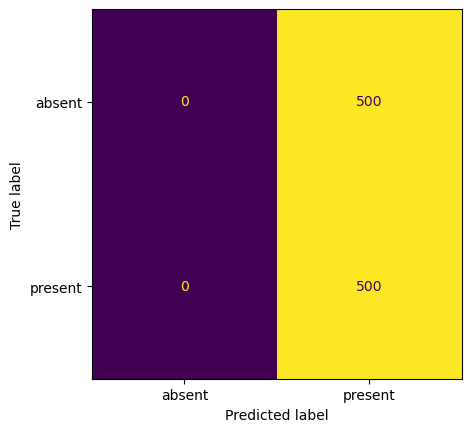

In [ ]:
def model_to_cm(model, df):
    shuf_preds = model.predict(df)
    shuf_preds['sigmoid_prediction'] = torch.sigmoid(torch.tensor(shuf_preds.target_presence.values))
    scores = shuf_preds.sigmoid_prediction.values
    targets = df.target_presence.values
    cm = opso.metrics.M.confusion_matrix(targets, scores.round())
    cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=['absent', 'present'])
    cm_display.plot(colorbar=False)
    return scores, targets

scores, targets = model_to_cm(model, shuffled_balanced_valid_df)


Using only focal samples for the present class has the effect of increasing precision at the expense of recall. This is for a threshold of 0.5, so other thresholds should be tried. 

# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 

In [ ]:
cleaned_valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")
# Remove the 'discard' samples from the validation set
cleaned_valid_df.drop(cleaned_valid_df.loc[cleaned_valid_df.confidence_cat == 1].index, inplace=True)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10694 [00:00<?, ?it/s]

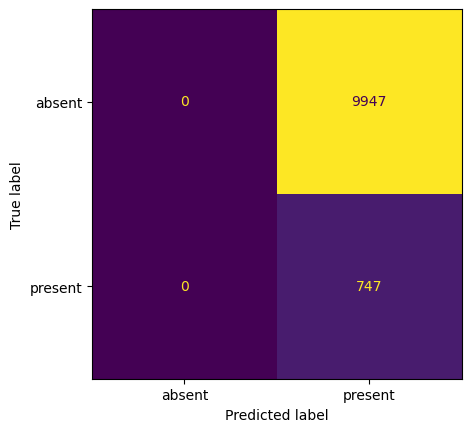

In [ ]:
scores, targets = model_to_cm(model, cleaned_valid_df)

In [ ]:
wandb.sklearn.plot_confusion_matrix(targets, scores.round(), ["absent", "present"])

# Look at the metrics across thresholds

In [ ]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-

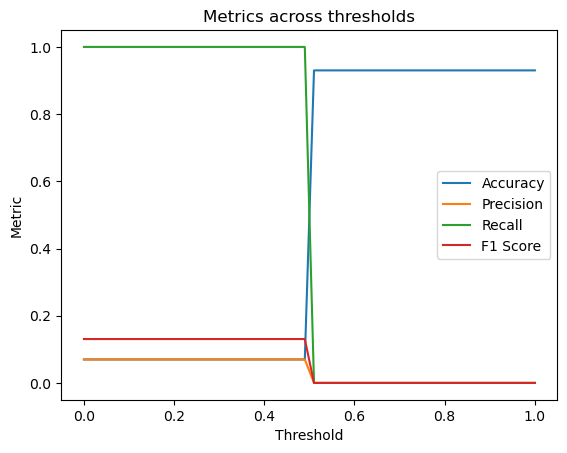

In [ ]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))

thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

In [ ]:
wandb.log(
    {
        "metrics": wandb.plot.line_series(
            xs= [thresholds, thresholds, thresholds, thresholds],
            ys=[accuracies, precisions, recalls, f1s],
            keys=legend,
            title="Metrics across thresholds",
            xname="threshold",
        )
    }
)

In [ ]:
def log_single_metric(metric, name):
    data = [[x, y] for (x, y) in zip(thresholds, metric)]
    table = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            f"custom {name}": wandb.plot.line(
                table, "x", "y", title=f"Custom {name} vs threshold plot"
            )
        }
    )
log_single_metric(accuracies, "accuracy")
log_single_metric(precisions, "precision")
log_single_metric(recalls, "recall")
log_single_metric(f1s, "f1")


# Result: 


# Save the best model

In [ ]:
date_time_id = dt
model_name = "verified_1000_1000"
# model.save(model_save_path / f"{model_name}_{date_time_id}")
# best_model = opso.cnn.load_model("best.model")
# best_model.save(model_save_path / f"best{model_name}_{date_time_id}")

# Export the index of the dataset used for training

In [ ]:
# ! mkdir -p {model_save_path / "training_indices"}
# shuffled_mixed_train_df.to_pickle(model_save_path / "training_indices" / f"seed_{random_seed}_{model_name}_{date_time_id}.pkl")

In [ ]:

wandb.finish()


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,14
loss,0.69318


In [ ]:
# model.save(model_save_path / f"balanced_mixed_1920_crashed_lr0008{dt}.model")